In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

In [2]:
emission_dict = {'low_fuel': [292.26, 278.83, 182.21, 216.93],
                'low_fuel_porous': [288.25, 279.72, 181.86, 220.49],
                'porous': [297.23, 283.12, 188.24, 222.74],
                'dense': [296.32, 279.91, 187.26, 218.04]}

### emission plot
def barth_2008(speed_mph_vector):
    
    b0 = 7.613534994965560
    b1 = -0.138565467462594
    b2 = 0.003915102063854
    b3 = -0.000049451361017
    b4 = 0.000000238630156 

    emission_gpermi_vector = np.exp(
        b0 + b1*speed_mph_vector  + b2*speed_mph_vector**2 + b3*speed_mph_vector**3 + b4*speed_mph_vector**4)

    return emission_gpermi_vector

In [3]:
edges_df = pd.read_csv('network_inputs/tokyo_edges.csv')
edges_df['edge_str'] = edges_df['start_nid'].astype('str') + '-' + edges_df['end_nid'].astype('str')
edges_df = edges_df.set_index('edge_str')
edges_df.head()

,u,v,highway,length,lanes,maxspeed,geometry,start_nid,end_nid,signal,type,capacity,fft
edge_str,,,,,,,,,,,,,
0-14135,131938557,6266083707,tertiary,51.500,1.0,40.0,"LINESTRING (139.851108 35.0268381, 139.8510964...",0,14135,0.5,tertiary,900.0,4.63500
0-184,131938557,305418247,secondary,45.162,1.0,60.0,"LINESTRING (139.851108 35.0268381, 139.8512008...",0,184,0.5,secondary,900.0,2.70972
0-8093,131938557,2466347437,secondary,184.183,1.0,60.0,"LINESTRING (139.851108 35.0268381, 139.8510121...",0,8093,0.5,secondary,900.0,11.05098
0-1821,131938557,1385663372,secondary,96.772,1.0,60.0,"LINESTRING (139.851108 35.0268381, 139.8511268...",0,1821,0.5,secondary,900.0,5.80632
1-1095,131939305,1385611951,residential,49.645,1.0,40.0,"LINESTRING (139.8495767 34.9850952, 139.849819...",1,1095,0.5,residential,900.0,4.46805


In [6]:
# edge_vol = pd.read_csv('simulation_outputs/edge_vol/edge_vol_hr14_qt1_emission_PM.csv')
edge_vol = pd.read_csv('simulation_outputs/edge_vol/edge_vol_hr14_qt1_time_PM.csv')
edge_vol['edge_str'] = edge_vol['start_nid'].astype('str') + '-' + edge_vol['end_nid'].astype('str')
edge_vol = edge_vol.set_index('edge_str')

edge_vol = edge_vol.join(edges_df['length'], how='left')
edge_vol['speed_kmph'] = (edge_vol['length']/1000)/(edge_vol['t_avg']/3600)
edge_vol['speed_mph'] = edge_vol['length']/edge_vol['t_avg']*2.237 ### m/s * 2.237 = mph
edge_vol['link_co2_g'] = barth_2008(edge_vol['speed_mph'])*edge_vol['vol_true']*edge_vol['length']/1609.34
print(np.sum(edge_vol['link_co2_g'])/1e6)
display(edge_vol.head())

2909.1762292516514


,start_nid,end_nid,veh_current,vol_true,vol_tot,flow,t_avg,length,speed_kmph,speed_mph,link_co2_g
edge_str,,,,,,,,,,,
0-1821,0,1821,0,113,139,452.0,6.03,96.772,57.774328,35.900326,2229.125841
0-184,0,184,0,4,5,16.0,2.71,45.162,59.993801,37.279481,36.625874
0-8093,0,8093,6,205,560,820.0,15.62,184.183,42.449347,26.377553,8483.318348
1-1112,1,1112,0,73,139,292.0,3.19,52.753,59.533166,36.993248,781.553736
10-1315,10,1315,0,4,6,16.0,2.09,40.732,70.160383,43.596882,32.719369


In [10]:
emission: 
barth 14,0: 1231.5; 2258.5
low_fuel 2029.4673370444975 2025.6833886599215
low_fuel_porous 2029.655593499497 2024.3923516200464
porous 2073.603017049897 2068.617338275384
dense 2053.103980838858 2050.6212708584944

distance:
14,0: 1866.9; 2909.2
low_fuel 2278.1467699221976 2251.6709561923362
low_fuel_porous 2278.3580942569356 2247.5095795137577
porous 2327.6905861774753 2300.99776439174
dense 2304.6797141726543 2282.2393076264602

1231.542671955675


In [7]:
for pavement_type, emission_values in emission_dict.items():
    total_emission = np.mean(emission_values) * np.sum(edge_vol['vol_true']*edge_vol['length']/1000) / 1e6 ### in tonne
    edge_vol['emission_factor'] = np.where(edge_vol['speed_kmph']<= 30, emission_values[0],
                                    np.where(edge_vol['speed_kmph']<= 50, emission_values[1],
                                      np.where(edge_vol['speed_kmph']<= 70, emission_values[2], emission_values[3])))
    speed_specific_emission = np.sum(edge_vol['emission_factor'] * edge_vol['vol_true']*edge_vol['length']/1000) / 1e6
    print(pavement_type, total_emission, speed_specific_emission)

low_fuel 2278.1467699221976 2251.6709561923362
low_fuel_porous 2278.3580942569356 2247.5095795137577
porous 2327.6905861774753 2300.99776439174
dense 2304.6797141726543 2282.2393076264602


In [15]:
emission_results = []
for hour in [13, 14]:
    for quarter in range(4):
        try:
            edge_vol = pd.read_csv('simulation_outputs/edge_vol/edge_vol_hr{}_qt{}_normal.csv'.format(hour, quarter))
        except FileNotFoundError:
            print('no file found')
            continue
        edge_vol['edge_str'] = edge_vol['start_nid'].astype('str') + '-' + edge_vol['end_nid'].astype('str')
        edge_vol = edge_vol.set_index('edge_str')
        edge_vol = edge_vol.join(edges_df['length'], how='left')
        edge_vol['speed_kmph'] = (edge_vol['length']/1000)/(edge_vol['t_avg']/3600)
        for pavement_type, emission_values in emission_dict.items():
            total_emission = np.mean(emission_values) * np.sum(edge_vol['vol_true']*edge_vol['length']/1000) / 1e6 ### in tonne
            edge_vol['emission_factor'] = np.where(edge_vol['speed_kmph']<= 30, emission_values[0],
                                            np.where(edge_vol['speed_kmph']<= 50, emission_values[1],
                                            np.where(edge_vol['speed_kmph']<= 70, emission_values[2], emission_values[3])))
            speed_specific_emission = np.sum(edge_vol['emission_factor'] * edge_vol['vol_true']*edge_vol['length']/1000) / 1e6
            emission_results.append([hour, quarter, pavement_type, total_emission, speed_specific_emission])

no file found


In [26]:
emission_results_df = pd.DataFrame(emission_results, columns=['hour', 'quarter', 'pavement_type', 'total_emission', 'speed_specific_emission'])
emission_results_df['time'] = emission_results_df['hour'] + 0.25*emission_results_df['quarter']
emission_results_df.tail()

,hour,quarter,pavement_type,total_emission,speed_specific_emission,time
23,14,1,dense,878.932367,859.913917,14.25
24,14,2,low_fuel,874.115150,860.245723,14.50
25,14,2,low_fuel_porous,874.196235,868.651025,14.50
26,14,2,porous,893.124900,879.153471,14.50
27,14,2,dense,884.295727,864.959520,14.50


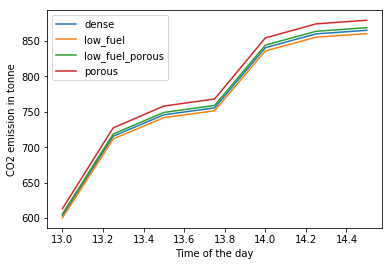

In [22]:
fig, ax = plt.subplots()
for pavement_type, grp in emission_results_df.groupby('pavement_type'):
    ax.plot(grp['time'], grp['speed_specific_emission'], label=pavement_type)
plt.xlabel('Time of the day')
plt.ylabel('CO2 emission in tonne')
plt.legend()
plt.show()

In [23]:
edge_vol_1 = pd.read_csv('simulation_outputs/edge_vol/edge_vol_hr13_qt3_normal.csv'.format(hour, quarter))
edge_vol_1['edge_str'] = edge_vol_1['start_nid'].astype('str') + '-' + edge_vol_1['end_nid'].astype('str')
edge_vol_1 = edge_vol_1.set_index('edge_str')

edge_vol_2 = pd.read_csv('simulation_outputs/edge_vol/edge_vol_hr13_qt3_2016_close.csv'.format(hour, quarter))
edge_vol_2['edge_str'] = edge_vol_2['start_nid'].astype('str') + '-' + edge_vol_2['end_nid'].astype('str')
edge_vol_2 = edge_vol_2.set_index('edge_str')

In [29]:
edge_vol_2 = edge_vol_2.join(edge_vol_1, lsuffix='_2', rsuffix='_1')

In [30]:
edge_vol_2.head()

,start_nid_2,end_nid_2,veh_current_2,vol_true_2,vol_tot_2,flow_2,t_avg_2,start_nid_1,end_nid_1,veh_current_1,vol_true_1,vol_tot_1,flow_1,t_avg_1
edge_str,,,,,,,,,,,,,,
509408-794943,509408,794943,14,12,17,48.0,1332.48,509408.0,794943.0,14.0,12.0,17.0,48.0,1332.48
794943-509408,794943,509408,31,17,40,68.0,1332.50,794943.0,509408.0,32.0,17.0,40.0,68.0,1332.50
772964-769031,772964,769031,1,1,3,4.0,1239.52,772964.0,769031.0,1.0,1.0,3.0,4.0,1239.52
769031-772964,769031,772964,0,1,1,4.0,1239.52,769031.0,772964.0,0.0,1.0,1.0,4.0,1239.52
157746-722530,157746,722530,2,1,1,4.0,1215.38,157746.0,722530.0,2.0,1.0,1.0,4.0,1215.38


In [31]:
edge_vol_2['flow_ratio'] = edge_vol_2['flow_2']/edge_vol_2['flow_1']
edge_vol_2['flow_ratio'].describe()

count    1.744348e+06
mean     1.006983e+00
std      2.221356e-01
min      3.278689e-03
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.040000e+02
Name: flow_ratio, dtype: float64

In [32]:
edge_vol_2.join(edges_df['geometry']).to_csv('edge_flow_ratio.csv', index=False)

In [33]:
edge_vol_2.head()

,start_nid_2,end_nid_2,veh_current_2,vol_true_2,vol_tot_2,flow_2,t_avg_2,start_nid_1,end_nid_1,veh_current_1,vol_true_1,vol_tot_1,flow_1,t_avg_1,flow_ratio
edge_str,,,,,,,,,,,,,,,
509408-794943,509408,794943,14,12,17,48.0,1332.48,509408.0,794943.0,14.0,12.0,17.0,48.0,1332.48,1.0
794943-509408,794943,509408,31,17,40,68.0,1332.50,794943.0,509408.0,32.0,17.0,40.0,68.0,1332.50,1.0
772964-769031,772964,769031,1,1,3,4.0,1239.52,772964.0,769031.0,1.0,1.0,3.0,4.0,1239.52,1.0
769031-772964,769031,772964,0,1,1,4.0,1239.52,769031.0,772964.0,0.0,1.0,1.0,4.0,1239.52,1.0
157746-722530,157746,722530,2,1,1,4.0,1215.38,157746.0,722530.0,2.0,1.0,1.0,4.0,1215.38,1.0
